In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/custom.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))


# Chapter 3 — Exploratory Data Analysis (EDA)
## Lesson 2: Pairwise Relationships (Correlation, Scatterplots)


### Learning objectives

By the end of this lesson, you will be able to:

- Distinguish **association** from **causation** and explain what correlation can and cannot prove.
- Compute and interpret **Pearson**, **Spearman**, and **Kendall** correlations (including when each is appropriate).
- Use **scatterplots** and related diagnostics (trend lines, residual views, log transforms) to detect:
  - linear vs nonlinear relationships,
  - heteroscedasticity,
  - outliers and leverage points,
  - subgroup structure and confounding signals.
- Handle mixed-type variables and choose suitable association measures:
  - point-biserial correlation (numeric ↔ binary),
  - correlation ratio $\eta^2$ (categorical ↔ numeric),
  - Cramér’s $V$ (categorical ↔ categorical).
- Build a repeatable **pairwise EDA workflow** that translates directly into modeling choices (transformations, feature selection, and leakage checks).

### Pairwise EDA: what you gain in practice

Pairwise analysis is the shortest path from “I have a CSV” to “I understand what models might work.” It reveals:

- **Redundancy** (two columns are near duplicates or measure the same concept).
- **Monotonicity** (a feature can be thresholded, binned, or modeled with monotonic constraints).
- **Nonlinearity** (suggests transforms, polynomial terms, splines, tree-based models).
- **Heteroscedasticity** (variance changes with level; impacts regression diagnostics and loss choice).
- **Outliers** (rare events, data entry errors, or genuinely extreme cases—each requires different handling).
- **Subgroup effects** (different relationships by category; signals interactions).

### Mathematical backbone: covariance and correlation

For random variables $X$ and $Y$ with finite second moments, covariance is

$$
\mathrm{Cov}(X,Y) = \mathbb{E}[(X-\mathbb{E}[X])(Y-\mathbb{E}[Y])].
$$

A common sample estimate is

$$
\widehat{\mathrm{Cov}}(X,Y) = \frac{1}{n-1}\sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y}).
$$

Pearson correlation normalizes covariance by standard deviations:

$$
\rho_{X,Y} = \frac{\mathrm{Cov}(X,Y)}{\sigma_X \sigma_Y}
\quad\Rightarrow\quad
\hat{\rho}_{X,Y} = \frac{\widehat{\mathrm{Cov}}(X,Y)}{s_X s_Y}.
$$

#### Geometric interpretation (highly useful intuition)

Let $x$ and $y$ be vectors of observations, and define centered vectors $\tilde{x}=x-\bar{x}\mathbf{1}$ and $\tilde{y}=y-\bar{y}\mathbf{1}$. Then

$$
\hat{\rho}_{X,Y} = \frac{\tilde{x}^\top \tilde{y}}{\|\tilde{x}\|\,\|\tilde{y}\|}.
$$

So Pearson correlation is the **cosine of the angle** between centered vectors. This immediately explains:

- $\rho=1$ means “same direction” (perfect positive linear relationship),
- $\rho=-1$ means “opposite direction” (perfect negative linear relationship),
- $\rho=0$ means orthogonality in centered space (no linear association).

This is why correlation is invariant to scaling and shifting (up to sign).

### Rank-based correlations

If relationships are **monotonic but not linear**, rank-based measures are often more informative:

- Spearman: Pearson on ranks  
  $$
  \rho_S = \mathrm{Corr}(\mathrm{rank}(X),\mathrm{rank}(Y)).
  $$
- Kendall’s $\tau$: based on concordant vs discordant pairs  
  $$
  \tau = \frac{(\#\text{concordant})-(\#\text{discordant})}{\binom{n}{2}}.
  $$

Ties (equal values) occur frequently in real datasets. Practical implementations use tie-adjusted variants (e.g., Kendall $\tau_b$).

### Scatterplots: “correlation with a face”

A single number can hide structure. Scatterplots let you see:

- curvature (suggests transforms or nonlinear models),
- outliers and leverage points,
- segmentation (clusters/subgroups),
- heteroscedasticity (variance changes),
- discretization artifacts (e.g., rounded or bucketed values).

In practice, compute correlations **and** look at scatterplots for the most important pairs.

---



## 1) Setup: libraries and helper utilities

We will use multiple datasets from your repository to practice pairwise analysis under different data types:

- purely numeric relationships,
- numeric targets (regression),
- categorical targets (classification),
- mixed categorical-to-numeric association.

The helper functions below support a repeatable workflow:

- consistent CSV loading by repository-relative paths,
- automatic numeric column detection,
- correlation tables and “top pairs” extraction,
- compact plotting utilities used throughout the lesson.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option('display.max_columns', 140)
pd.set_option('display.width', 160)
sns.set_context('notebook')

def load_csv(rel_path: str) -> pd.DataFrame:
    path = Path(rel_path)
    if not path.exists():
        raise FileNotFoundError(f"CSV not found at: {path.resolve()} (expected relative path: {rel_path})")
    return pd.read_csv(path)

def coerce_numeric(df: pd.DataFrame, cols=None) -> pd.DataFrame:
    out = df.copy()
    if cols is None:
        cols = out.columns
    for c in cols:
        if out[c].dtype == 'object':
            try:
                out[c] = pd.to_numeric(out[c])
            except Exception:
                # Keep original if conversion is not possible
                pass
    return out

def numeric_columns(df: pd.DataFrame):
    return [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]

def correlation_table(df: pd.DataFrame, method: str = 'pearson') -> pd.DataFrame:
    num = df[numeric_columns(df)].copy()
    return num.corr(method=method)

def top_abs_correlations(corr: pd.DataFrame, k: int = 12) -> pd.DataFrame:
    c = corr.copy()
    np.fill_diagonal(c.values, np.nan)
    # pandas >= 2.1 introduces stack(..., future_stack=True) where dropna must be unspecified
    try:
        s = c.stack(future_stack=True)
        s = s.dropna()
    except TypeError:
        # Older pandas: dropna parameter exists and can remove NA rows during stacking
        s = c.stack(dropna=True)
    pairs = s.rename('corr').to_frame()
    pairs['abs_corr'] = pairs['corr'].abs()
    return pairs.sort_values('abs_corr', ascending=False).head(k)

def show_corr_heatmap(df: pd.DataFrame, method='pearson', title=''):
    corr = correlation_table(df, method=method)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap='coolwarm', center=0, square=True, linewidths=0.5)
    plt.title(title or f"Correlation heatmap ({method})")
    plt.tight_layout()
    plt.show()
    return corr

def scatter_with_fit(df: pd.DataFrame, x: str, y: str, *, title='', sample=5000, random_state=0, logx=False, logy=False):
    sub = df[[x, y]].dropna().copy()
    if len(sub) > sample:
        sub = sub.sample(sample, random_state=random_state)
    if logx:
        sub = sub[sub[x] > 0]
        sub[x] = np.log(sub[x])
    if logy:
        sub = sub[sub[y] > 0]
        sub[y] = np.log(sub[y])
    plt.figure(figsize=(7, 5))
    sns.scatterplot(data=sub, x=x, y=y, alpha=0.5)
    sns.regplot(data=sub, x=x, y=y, scatter=False)
    plt.title(title or f"{x} vs {y}")
    plt.tight_layout()
    plt.show()
    return sub

def groupwise_corr(df: pd.DataFrame, group_col: str, x: str, y: str, method: str = 'pearson') -> pd.Series:
    """Compute correlation within each group without GroupBy.apply deprecation warnings."""
    d = df[[group_col, x, y]].dropna()
    out = {}
    for g, sub in d.groupby(group_col, sort=False):
        out[g] = sub[[x, y]].corr(method=method).iloc[0, 1]
    return pd.Series(out).sort_values(ascending=False)



## 2) Load multiple datasets

We will intentionally use **multiple** datasets so you can see how pairwise methods behave across domains:

- **House prices** (regression-like economics data)
- **Diamonds** (nonlinear monotonic pricing)
- **Diabetes** (binary classification with numeric features)
- **Iris** (multiclass classification with clean numeric features)
- **Height/Weight** (simple relationship, good for diagnostics)
- **Wine quality** (many correlated numeric chemistry variables)
- **Cognitive** (regression target with categorical predictors)
- **Stars** (mixed categorical and numeric)
- **Salaries** (small dataset for categorical visualization)

This variety matters because “the right plot” depends on type, scale, noise, and sample size.


In [3]:
paths = {
    'diabetes': '../../../Datasets/Classification/diabetes.csv',
    'iris': '../../../Datasets/Classification/iris.csv',
    'diamonds': '../../../Datasets/Regression/diamonds.csv',
    'house_prices': '../../../Datasets/Regression/house-prices.csv',
    'hw_200': '../../../Datasets/Clustering/hw_200.csv',
    'wine': '../../../Datasets/Classification/Wine_Quality.csv',
    'stars': '../../../Datasets/Classification/stars.csv',
    'cognitive': '../../../Datasets/Regression/cognitive.csv',
    'salaries': '../../../Datasets/Regression/salaries.csv',
}

data = {name: coerce_numeric(load_csv(p)) for name, p in paths.items()}

for name, df in data.items():
    print(f"{name}: shape={df.shape}")
    display(df.head(5))


diabetes: shape=(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification
0,6,148,72,35,0,33.6,0.627,50,Diabetic
1,1,85,66,29,0,26.6,0.351,31,Non-Diabetic
2,8,183,64,0,0,23.3,0.672,32,Diabetic
3,1,89,66,23,94,28.1,0.167,21,Non-Diabetic
4,0,137,40,35,168,43.1,2.288,33,Diabetic


iris: shape=(150, 5)


,sepal_length,sepal_width,petal_length,petal_width,classification
0,5.4,3.7,1.5,0.2,Iris-setosa
1,4.8,3.4,1.6,0.2,Iris-setosa
2,4.8,3.0,1.4,0.1,Iris-setosa
3,4.3,3.0,1.1,0.1,Iris-setosa
4,5.8,4.0,1.2,0.2,Iris-setosa


diamonds: shape=(53940, 11)


,id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


house_prices: shape=(128, 8)


,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East


hw_200: shape=(200, 3)


,Index,"Height(Inches)""","""Weight(Pounds)"""
0,1,65.78,112.99
1,2,71.52,136.49
2,3,69.40,153.03
3,4,68.22,142.34
4,5,67.79,144.30


wine: shape=(4898, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


stars: shape=(240, 7)


,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,Red Dwarf
1,3042,0.000500,0.1542,16.60,Red,M,Red Dwarf
2,2600,0.000300,0.1020,18.70,Red,M,Red Dwarf
3,2800,0.000200,0.1600,16.65,Red,M,Red Dwarf
4,1939,0.000138,0.1030,20.06,Red,M,Red Dwarf


cognitive: shape=(434, 5)


,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,yes,121.117529,yes,27
1,98,yes,89.361882,yes,25
2,85,yes,115.443165,yes,27
3,83,yes,99.449639,yes,25
4,115,yes,92.745710,yes,27


salaries: shape=(1000, 4)


,Name,Age,Job,Salary
0,Kevin Sanders,24,Software Engineer,7300
1,Lisa Mills,26,High School Teacher,6100
2,Donna Allison,27,Dentist,12700
3,Michael Schmitt,43,Dentist,17500
4,Lisa Shaffer,31,Accountant,7400



## 3) Correlation matrices: fast overview (numeric ↔ numeric)

A correlation matrix is a compact summary for numeric variables. It answers:

- Which predictors are near duplicates?
- Which groups of features move together?
- Are there suspicious near-perfect correlations?

### 3.1) Choosing a correlation type

A practical decision guide:

- Use **Pearson** when you expect approximately linear relationships and outliers are not dominating.
- Use **Spearman** when relationships might be monotonic but nonlinear, or when you want robustness to outliers.
- Use **Kendall** when you want an interpretable rank association in terms of concordant/discordant pairs (often more conservative).

A good habit is to compute Pearson and Spearman and compare. If Spearman is high but Pearson is notably lower, the relationship may be monotonic but nonlinear (or contaminated by outliers).

### 3.2) Pairwise deletion and missing values (important detail)

Correlation computations typically use **pairwise** non-missing rows for each pair. That means different correlations may be computed on different subsets, which can produce inconsistencies if missingness is structured.

In EDA, this is acceptable as long as you:

- keep an eye on missingness rates,
- verify key relationships on a consistent subset when needed.


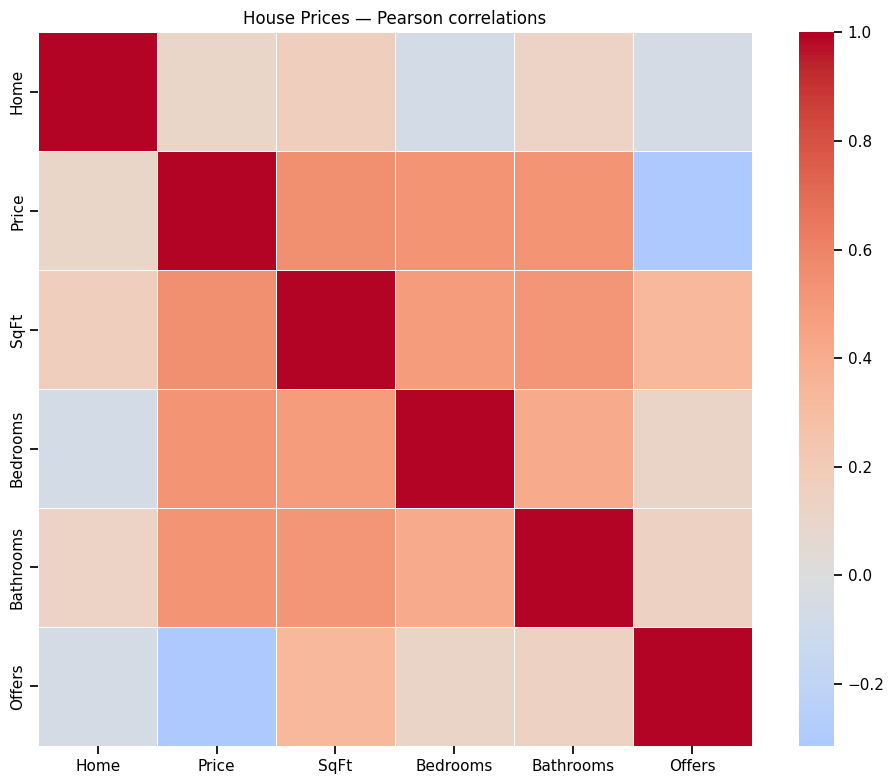

corr  abs_corr
SqFt      Price      0.552982  0.552982
Price     SqFt       0.552982  0.552982
          Bedrooms   0.525926  0.525926
Bedrooms  Price      0.525926  0.525926
Bathrooms Price      0.523258  0.523258
Price     Bathrooms  0.523258  0.523258
SqFt      Bathrooms  0.522745  0.522745
Bathrooms SqFt       0.522745  0.522745
Bedrooms  SqFt       0.483807  0.483807
SqFt      Bedrooms   0.483807  0.483807
Bedrooms  Bathrooms  0.414556  0.414556
Bathrooms Bedrooms   0.414556  0.414556

In [4]:
house = data['house_prices'].copy()
corr_house = show_corr_heatmap(house, method='pearson', title='House Prices — Pearson correlations')
display(top_abs_correlations(corr_house, k=12))


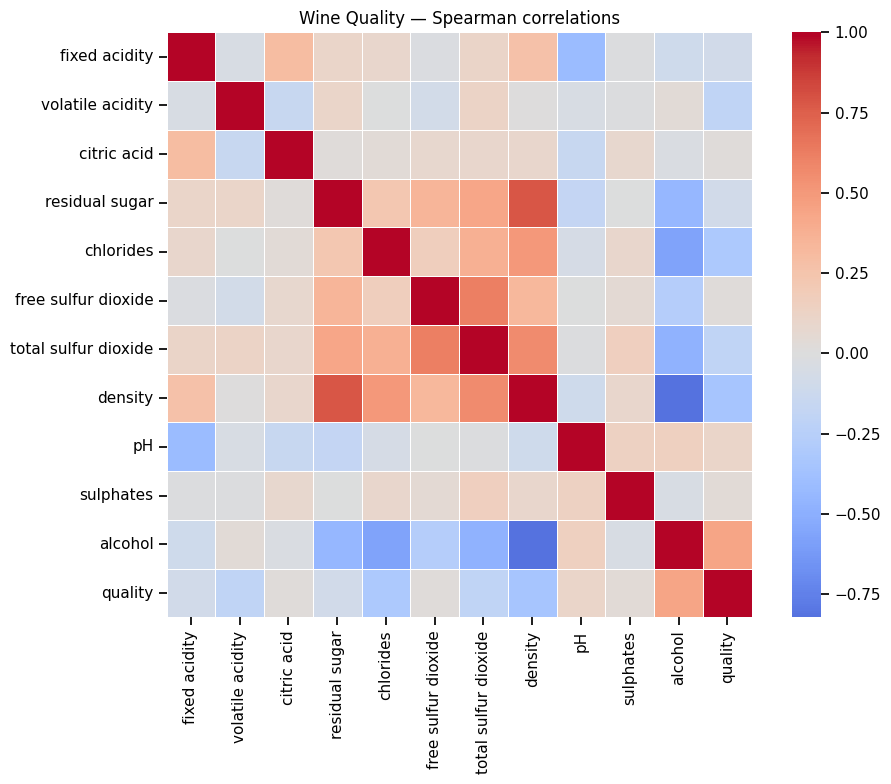

,,corr,abs_corr
density,alcohol,-0.821855,0.821855
alcohol,density,-0.821855,0.821855
density,residual sugar,0.780365,0.780365
residual sugar,density,0.780365,0.780365
total sulfur dioxide,free sulfur dioxide,0.618616,0.618616
free sulfur dioxide,total sulfur dioxide,0.618616,0.618616
chlorides,alcohol,-0.570806,0.570806
alcohol,chlorides,-0.570806,0.570806
density,total sulfur dioxide,0.563824,0.563824
total sulfur dioxide,density,0.563824,0.563824


In [5]:
wine = data['wine'].copy()
corr_wine = show_corr_heatmap(wine, method='spearman', title='Wine Quality — Spearman correlations')
display(top_abs_correlations(corr_wine, k=15))



## 4) Interpreting correlation correctly (and avoiding common traps)

### 4.1) Correlation does not imply causation

Even if $\rho$ is high, it may be driven by:

- a hidden variable $Z$ that influences both $X$ and $Y$ (confounding),
- selection bias (you only observe a biased subset),
- a common time trend (spurious correlation in time series),
- group mixing (Simpson’s paradox),
- measurement coupling (one variable is computed from the other).

In ML terms: correlation indicates **predictive association** under the current data-generating process—not what would happen under interventions.

### 4.2) Zero correlation can still mean strong dependence

Pearson correlation measures linear association. Consider $Y=X^2$ with $X$ symmetric around 0; the correlation between $X$ and $X^2$ can be near zero, even though $Y$ is fully determined by $X$. Scatterplots are essential.

### 4.3) Correlation magnitude: what is “large”?

There is no universal threshold. Practical judgment depends on:

- domain context,
- noise level,
- sample size,
- whether the feature will be used alone or combined with others,
- stability under resampling and across slices.

A robust practice is to combine:

- effect size (|corr|),
- visual shape check (scatterplot),
- stability check (bootstrap interval),
- subgroup consistency check.

### 4.4) Fisher transformation (useful for quick approximate intervals)

For Pearson correlation $r$, a normalizing transform is:

$$
z = \frac{1}{2}\ln\left(\frac{1+r}{1-r}\right).
$$

For moderate $n$, $z$ is approximately normal with standard error $1/\sqrt{n-3}$.



### 4.5) Demonstration: strong nonlinear dependence with near-zero Pearson correlation

We construct $X \sim \mathrm{Uniform}(-1,1)$ and $Y=X^2+\epsilon$.

- Scatterplot shows a clear U-shape (strong dependence).
- Pearson correlation between $X$ and $Y$ is near zero.
- Spearman correlation may also be small because the relationship is not monotonic.


Pearson corr(X, Y): -0.012851601186206669
Spearman corr(X, Y): 0.02023599477155323
Kendall corr(X, Y): 0.024030242383811427


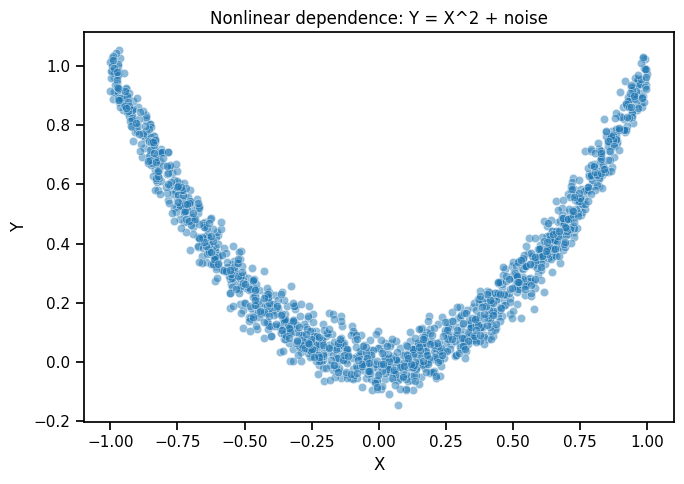

In [6]:
rng = np.random.default_rng(0)
X = rng.uniform(-1, 1, size=1500)
eps = rng.normal(0, 0.05, size=1500)
Y = X**2 + eps

print('Pearson corr(X, Y):', pd.Series(X).corr(pd.Series(Y), method='pearson'))
print('Spearman corr(X, Y):', pd.Series(X).corr(pd.Series(Y), method='spearman'))
print('Kendall corr(X, Y):', pd.Series(X).corr(pd.Series(Y), method='kendall'))

plt.figure(figsize=(7,5))
sns.scatterplot(x=X, y=Y, alpha=0.5)
plt.title('Nonlinear dependence: Y = X^2 + noise')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()



## 5) Scatterplots beyond the basics: practical variants

Real datasets often require plot variants to reveal structure.

### 5.1) Alpha blending (transparency)

When there are many points, overplotting hides density. Setting `alpha` helps you see dense regions.

### 5.2) Hexbin (2D binning)

A hexbin plot shows counts in hexagonal bins, useful for large datasets.

### 5.3) Joint plots with marginal distributions

Marginal histograms or KDEs help you understand each variable’s distribution alongside their relationship.

We demonstrate these variants on diamonds (large) and then show jitter on a small categorical example (salaries).


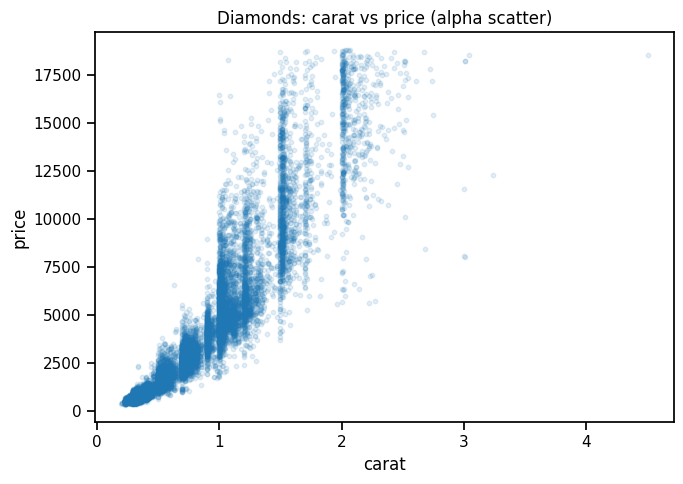

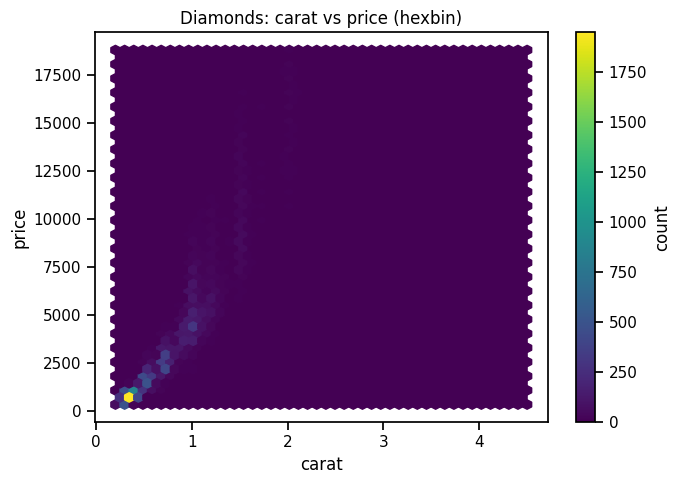

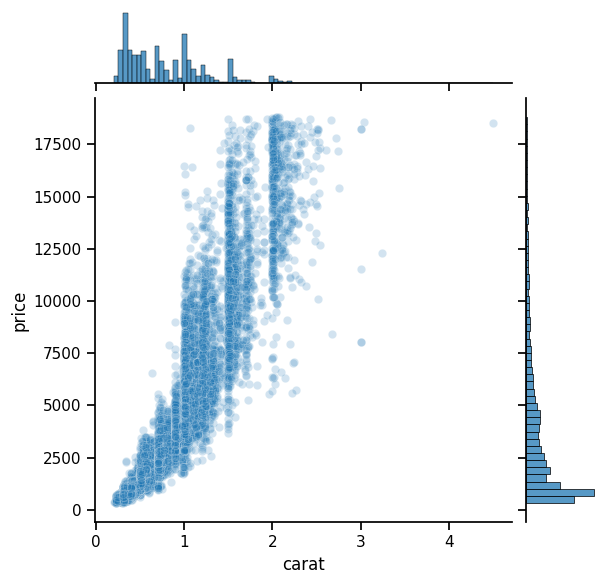

In [7]:
diamonds = data['diamonds'].copy()
diam_num = diamonds[['carat','price']].dropna()
sample = diam_num.sample(min(15000, len(diam_num)), random_state=1)

# Alpha blending scatter
plt.figure(figsize=(7,5))
plt.scatter(sample['carat'], sample['price'], alpha=0.12, s=10)
plt.title('Diamonds: carat vs price (alpha scatter)')
plt.xlabel('carat')
plt.ylabel('price')
plt.tight_layout()
plt.show()

# Hexbin
plt.figure(figsize=(7,5))
plt.hexbin(sample['carat'], sample['price'], gridsize=45)
plt.title('Diamonds: carat vs price (hexbin)')
plt.xlabel('carat')
plt.ylabel('price')
plt.colorbar(label='count')
plt.tight_layout()
plt.show()

# Joint plot with marginals
sns.jointplot(data=sample, x='carat', y='price', kind='scatter', height=6, alpha=0.2)
plt.show()



### 5.4) Jitter for discrete/categorical x-axes

If $X$ is categorical, a scatterplot needs a mapping to positions. For visualization, you can:

- map categories to integer codes,
- add small noise (jitter) to reduce overplotting,
- validate patterns with groupwise statistics.

We do that for the salaries dataset (Salary by Job).


,Name,Age,Job,Salary
0,Kevin Sanders,24,Software Engineer,7300
1,Lisa Mills,26,High School Teacher,6100
2,Donna Allison,27,Dentist,12700
3,Michael Schmitt,43,Dentist,17500
4,Lisa Shaffer,31,Accountant,7400


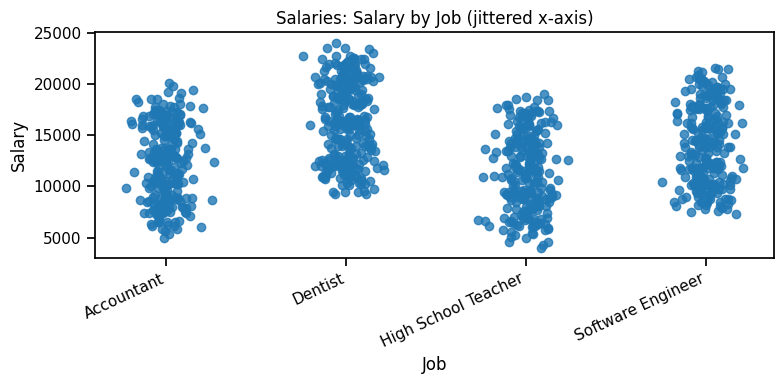

,count,mean,std,min,25%,50%,75%,max
Job,,,,,,,,
Accountant,243.0,12327.983539,3726.102761,5000.0,9000.0,12500.0,15750.0,20100.0
Dentist,267.0,16295.505618,3890.027063,9300.0,12650.0,16300.0,19700.0,24100.0
High School Teacher,242.0,11402.066116,3733.902638,4000.0,8500.0,11250.0,14300.0,19100.0
Software Engineer,248.0,14127.419355,3850.281839,7300.0,10700.0,14000.0,17600.0,21600.0


In [8]:
salaries = data['salaries'].copy()
display(salaries.head())

salaries['JobCode'] = salaries['Job'].astype('category').cat.codes
rng = np.random.default_rng(3)
salaries['JobCode_jitter'] = salaries['JobCode'] + rng.normal(0, 0.08, size=len(salaries))

plt.figure(figsize=(8,4))
plt.scatter(salaries['JobCode_jitter'], salaries['Salary'], alpha=0.8)
plt.xticks(ticks=range(salaries['JobCode'].nunique()), labels=salaries['Job'].astype('category').cat.categories, rotation=25, ha='right')
plt.title('Salaries: Salary by Job (jittered x-axis)' if True else '')
plt.xlabel('Job')
plt.ylabel('Salary')
plt.tight_layout()
plt.show()

display(salaries.groupby('Job')['Salary'].describe())



## 6) A repeatable scatterplot workflow (with examples)

For a candidate pair $(X,Y)$, a practical workflow is:

1. Look at basic scatter (alpha or hexbin if dense).
2. Compare Pearson vs Spearman.
3. Consider transformations (log, sqrt, power transforms) when patterns curve.
4. Check residuals from a simple line to detect curvature and heteroscedasticity.
5. Check sensitivity to outliers (robust filtering).
6. Slice by categories when confounding or interactions are plausible.

We apply this workflow to:

- house prices: SqFt vs Price
- height/weight: Height vs Weight
- cognitive: mom_iq vs kid_score (with slicing by mom_hs)


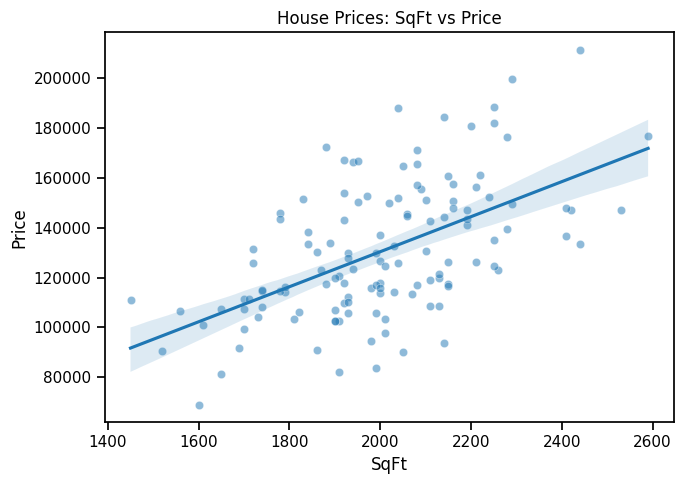

Pearson: 0.5529822425554837
Spearman: 0.5546133629830046
Kendall: 0.3841470703276054


In [9]:
scatter_with_fit(house, 'SqFt', 'Price', title='House Prices: SqFt vs Price')

print('Pearson:', house[['SqFt','Price']].corr(method='pearson').iloc[0,1])
print('Spearman:', house[['SqFt','Price']].corr(method='spearman').iloc[0,1])
print('Kendall:', house[['SqFt','Price']].corr(method='kendall').iloc[0,1])



### 6.1) Residual view and log-transform hint (house prices)

Residuals from a linear fit:

$$
e_i = y_i - (\hat{\beta}_0 + \hat{\beta}_1 x_i).
$$

Patterns in $e_i$ vs $x_i$ suggest:

- systematic curvature (nonlinearity),
- changing spread (heteroscedasticity).

A common exploratory check is to compare the raw scale with log($Y$).


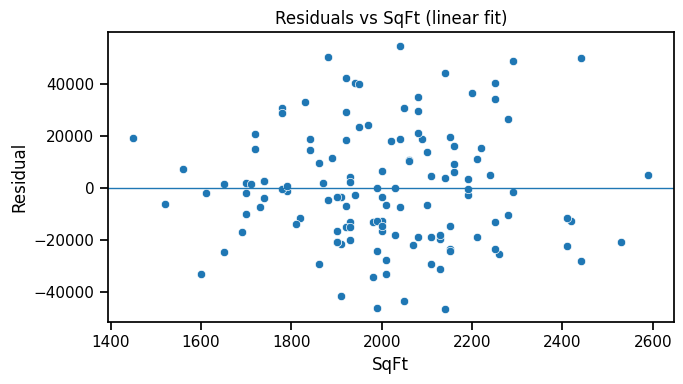

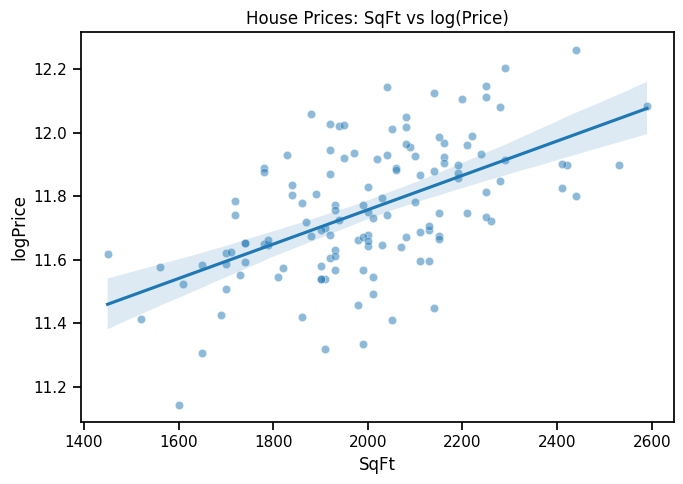

,SqFt,logPrice
0,1790,11.646582
1,2030,11.645707
2,1740,11.650947
3,1980,11.458469
4,2130,11.693579
...,...,...
123,1900,11.692744
124,2160,11.904292
125,2070,11.639558
126,2020,11.917724


In [10]:
import numpy.linalg as la
x = house['SqFt'].to_numpy(dtype=float)
y = house['Price'].to_numpy(dtype=float)
Xmat = np.c_[np.ones_like(x), x]
beta = la.lstsq(Xmat, y, rcond=None)[0]
y_hat = Xmat @ beta
resid = y - y_hat

plt.figure(figsize=(7,4))
sns.scatterplot(x=x, y=resid)
plt.axhline(0, linewidth=1)
plt.title('Residuals vs SqFt (linear fit)')
plt.xlabel('SqFt')
plt.ylabel('Residual')
plt.tight_layout()
plt.show()

house2 = house.copy()
house2['logPrice'] = np.log(house2['Price'])
scatter_with_fit(house2, 'SqFt', 'logPrice', title='House Prices: SqFt vs log(Price)')



### 6.2) Example: height vs weight (simple linear-ish relationship)

If variables are standardized (z-scored), the regression slope equals correlation:

$$
\beta_1^{(z)} = r.
$$

We will:

1. Plot Height vs Weight,
2. Compute correlations,
3. Fit a simple line,
4. Compute the standardized slope.


,Index,Height(Inches),Weight(Pounds)
0,1,65.78,112.99
1,2,71.52,136.49
2,3,69.40,153.03
3,4,68.22,142.34
4,5,67.79,144.30


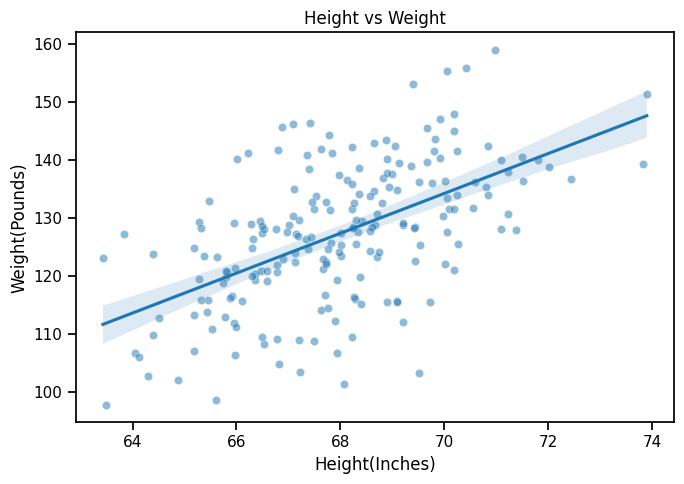

Pearson: 0.5568647346123003
Spearman: 0.5507608131620684
Standardized slope: 0.5568647346122994


In [11]:
hw = data['hw_200'].copy()
hw.columns = [c.strip().strip('"') for c in hw.columns]
hw = hw.rename(columns={c: c.replace(' ', '') for c in hw.columns})
display(hw.head())

xcol = [c for c in hw.columns if 'Height' in c][0]
ycol = [c for c in hw.columns if 'Weight' in c][0]

scatter_with_fit(hw, xcol, ycol, title='Height vs Weight')

r_p = hw[[xcol, ycol]].corr(method='pearson').iloc[0,1]
r_s = hw[[xcol, ycol]].corr(method='spearman').iloc[0,1]
print('Pearson:' if True else '', r_p)
print('Spearman:' if True else '', r_s)

xz = (hw[xcol] - hw[xcol].mean()) / hw[xcol].std(ddof=1)
yz = (hw[ycol] - hw[ycol].mean()) / hw[ycol].std(ddof=1)
Xz = np.c_[np.ones(len(xz)), xz.to_numpy()]
bz = np.linalg.lstsq(Xz, yz.to_numpy(), rcond=None)[0]
print('Standardized slope:', bz[1])



### 6.3) Example: cognitive dataset — mom_iq vs kid_score (with subgroup slicing)

We add a categorical slice (`mom_hs`) to see if the association differs by group.


,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,yes,121.117529,yes,27
1,98,yes,89.361882,yes,25
2,85,yes,115.443165,yes,27
3,83,yes,99.449639,yes,25
4,115,yes,92.745710,yes,27


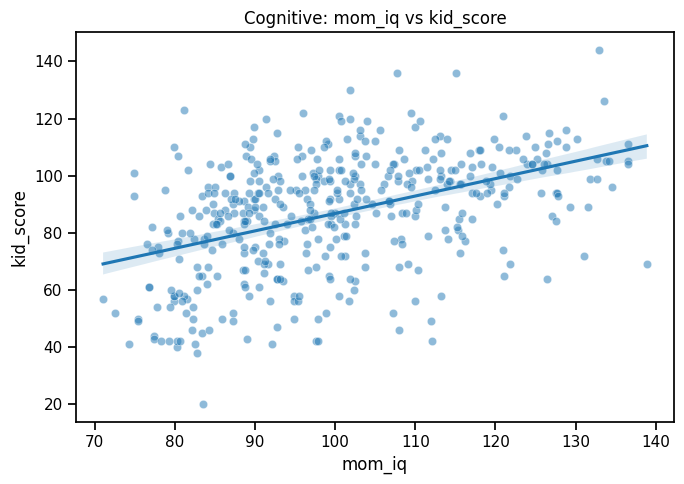

Pearson: 0.44827584227897366
Spearman: 0.4612033857889969


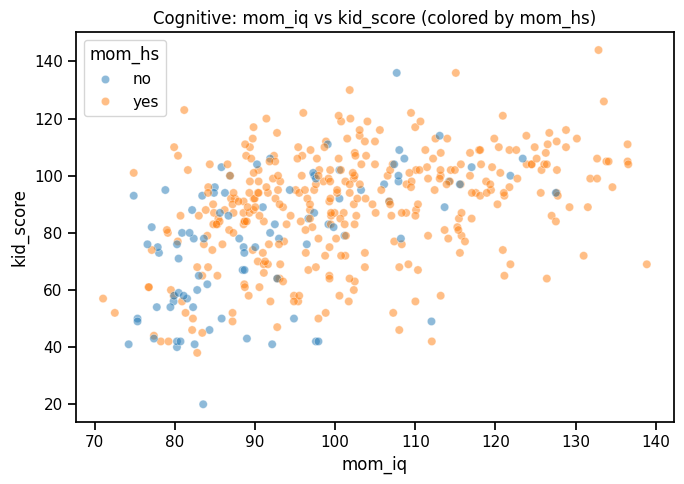

,Pearson corr within group
no,0.542113
yes,0.377740


In [12]:
cog = data['cognitive'].copy()
display(cog.head())

scatter_with_fit(cog, 'mom_iq', 'kid_score', title='Cognitive: mom_iq vs kid_score', sample=20000)
print('Pearson:', cog[['mom_iq','kid_score']].corr(method='pearson').iloc[0,1])
print('Spearman:', cog[['mom_iq','kid_score']].corr(method='spearman').iloc[0,1])

sub = cog[['mom_iq','kid_score','mom_hs']].dropna().sample(min(6000, len(cog)), random_state=9)
plt.figure(figsize=(7,5))
sns.scatterplot(data=sub, x='mom_iq', y='kid_score', hue='mom_hs', alpha=0.5)
plt.title('Cognitive: mom_iq vs kid_score (colored by mom_hs)')
plt.tight_layout()
plt.show()

by = groupwise_corr(sub, 'mom_hs', 'mom_iq', 'kid_score', method='pearson')
display(by.to_frame('Pearson corr within group'))



## 7) Scatterplot matrices and pair plots (multivariate pairwise views)

Pair plots provide an efficient visual scan across many pairs. For supervised data, using `hue=` shows whether classes separate along certain feature pairs.

We use iris as a clean multiclass example.


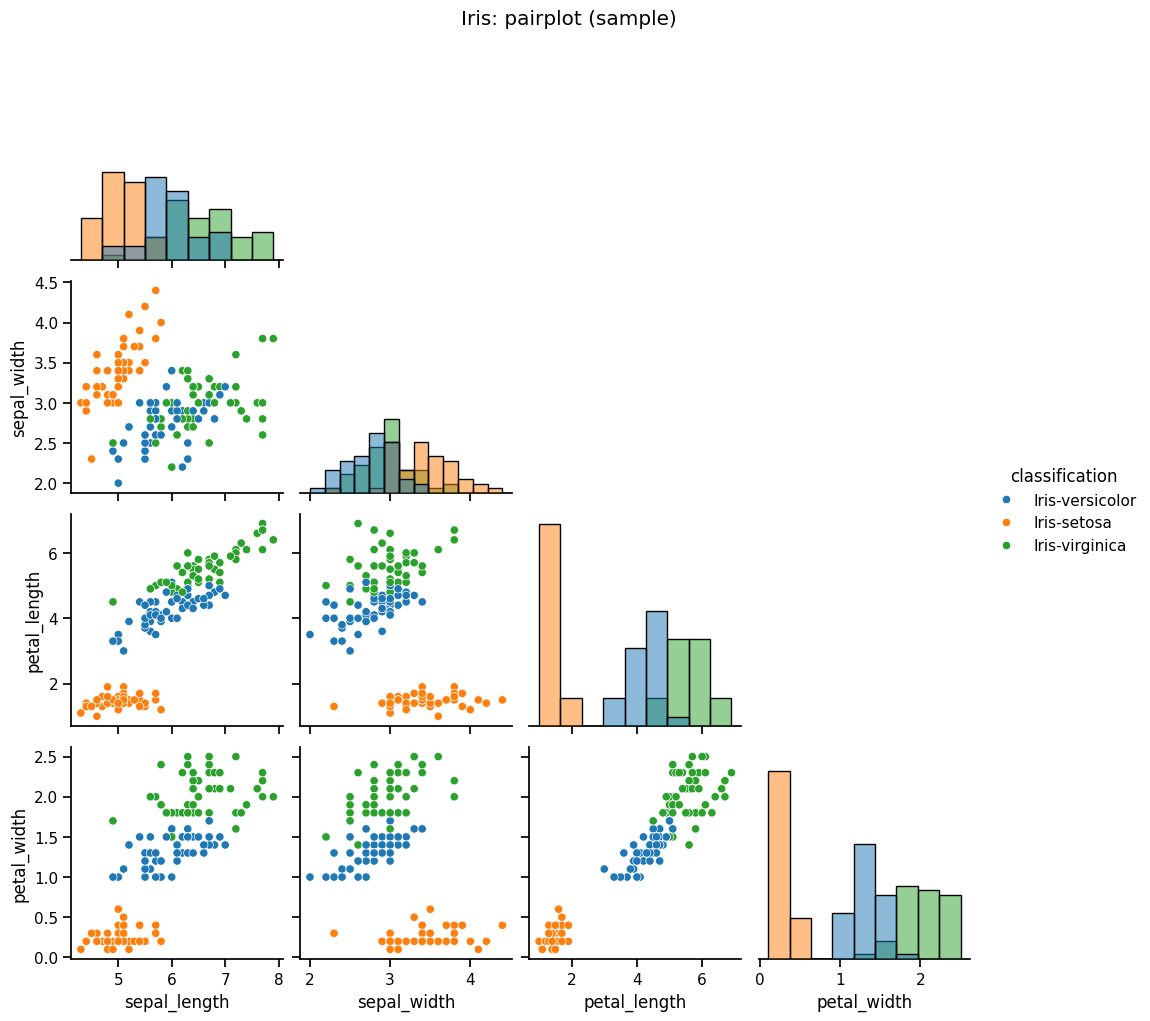

In [13]:
iris = data['iris'].copy()
num_cols = [c for c in iris.columns if c != 'classification' and pd.api.types.is_numeric_dtype(iris[c])]
sample_iris = iris.sample(min(200, len(iris)), random_state=42)
sns.pairplot(sample_iris, vars=num_cols, hue='classification', corner=True, diag_kind='hist')
plt.suptitle('Iris: pairplot (sample)', y=1.02)
plt.show()



## 8) Mixed types: beyond numeric↔numeric correlation

### 8.1) Numeric ↔ binary: point-biserial correlation

If $Y$ is binary (0/1) and $X$ is numeric, point-biserial equals Pearson correlation between $X$ and $Y$. We apply it to diabetes, and validate with violin plots (distribution by class).


,corr_with_label
Glucose,0.466581
BMI,0.292695
Age,0.238356
Pregnancies,0.221898
DiabetesPedigreeFunction,0.173844
Insulin,0.130548
SkinThickness,0.074752
BloodPressure,0.065068


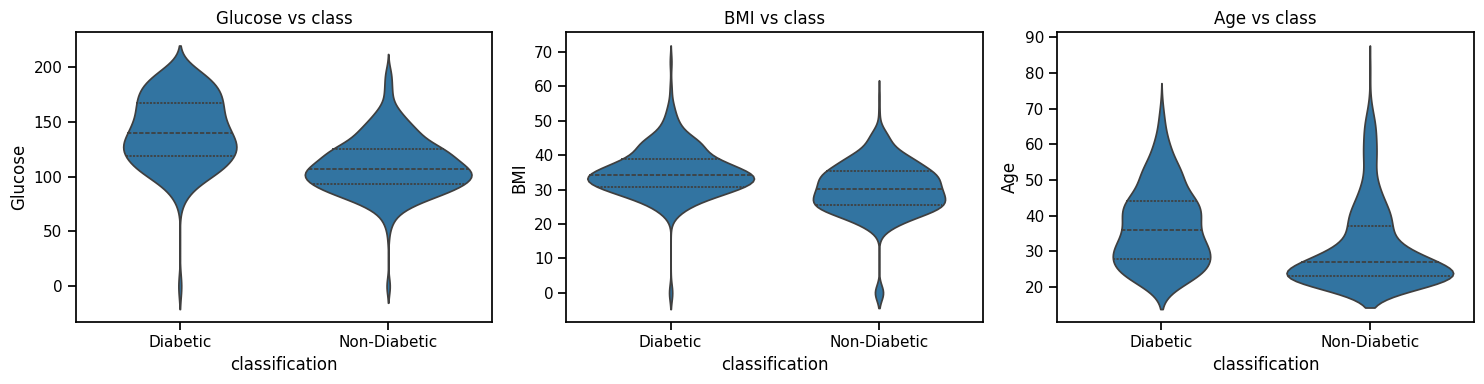

In [14]:
diab = data['diabetes'].copy()
label_map = {'Diabetic': 1, 'Non-Diabetic': 0}
diab['y'] = diab['classification'].map(label_map)
num_cols = [c for c in diab.columns if c not in ['classification','y'] and pd.api.types.is_numeric_dtype(diab[c])]
corrs = diab[num_cols + ['y']].corr()['y'].drop('y').sort_values(key=lambda s: s.abs(), ascending=False)
display(corrs.to_frame('corr_with_label'))

top3 = corrs.index[:3].tolist()
fig, axes = plt.subplots(1, 3, figsize=(15,4))
for ax, c in zip(axes, top3):
    sns.violinplot(data=diab, x='classification', y=c, ax=ax, inner='quartile')
    ax.set_title(f'{c} vs class')
plt.tight_layout()
plt.show()



### 8.2) Categorical (multi-class) ↔ numeric: correlation ratio $\eta^2$

For a categorical variable $G$ with groups $g$ and numeric $X$, a useful effect size is

$$
\eta^2 = \frac{\sum_g n_g(\bar{x}_g - \bar{x})^2}{\sum_i (x_i - \bar{x})^2}.
$$

Interpretation: fraction of variance in $X$ explained by group membership.

We demonstrate using stars: Temperature explained by Spectral_Class.


eta^2(Temperature ~ Spectral_Class) = 0.7097704447020484


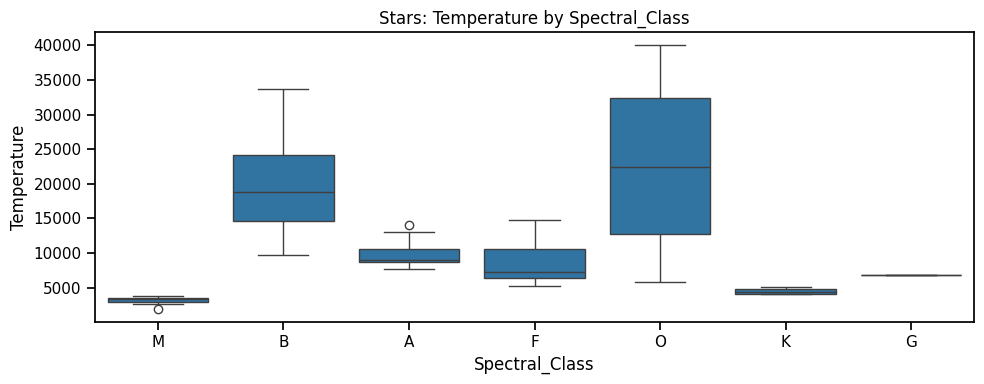

In [15]:
stars = data['stars'].copy()
def eta_squared(x: pd.Series, g: pd.Series) -> float:
    df = pd.DataFrame({'x': x, 'g': g}).dropna()
    x = df['x']
    overall_mean = x.mean()
    ss_between = df.groupby('g')['x'].apply(lambda s: len(s) * (s.mean() - overall_mean) ** 2).sum()
    ss_total = ((x - overall_mean) ** 2).sum()
    return float(ss_between / ss_total) if ss_total > 0 else np.nan

eta = eta_squared(stars['Temperature'], stars['Spectral_Class'])
print('eta^2(Temperature ~ Spectral_Class) =', eta)

plt.figure(figsize=(10,4))
sns.boxplot(data=stars, x='Spectral_Class', y='Temperature')
plt.title('Stars: Temperature by Spectral_Class')
plt.tight_layout()
plt.show()



### 8.3) Categorical ↔ categorical: Cramér’s $V$

For two categorical variables $A$ and $B$, Cramér’s $V$ uses the $\chi^2$ statistic:

$$
V = \sqrt{\frac{\chi^2 / n}{\min(k-1,\;r-1)}},
$$

where $r$ and $k$ are the number of categories. We demonstrate on diamonds: cut vs color.


Cramér's V(cut, color) = 0.037924332663570634


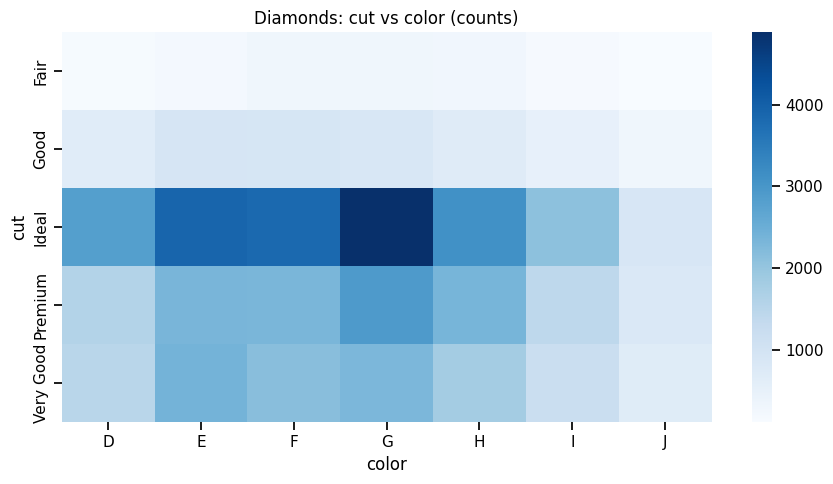

In [16]:
from scipy.stats import chi2_contingency
d_cat = data['diamonds'][['cut','color']].dropna().copy()
ct = pd.crosstab(d_cat['cut'], d_cat['color'])
chi2, p, dof, expected = chi2_contingency(ct)
n = ct.values.sum()
r, k = ct.shape
cramers_v = np.sqrt((chi2 / n) / (min(k - 1, r - 1)))
print("Cramér's V(cut, color) =", cramers_v)

plt.figure(figsize=(9,5))
sns.heatmap(ct, cmap='Blues')
plt.title('Diamonds: cut vs color (counts)')
plt.tight_layout()
plt.show()



### 8.4) Mutual information (MI) as a nonlinear screening tool

Mutual information is

$$
I(X;Y) = \mathbb{E}\left[\log\frac{p(X,Y)}{p(X)p(Y)}\right].
$$

MI can detect nonlinear dependence. We estimate MI between diabetes features and the binary label using scikit-learn.


In [17]:
from sklearn.feature_selection import mutual_info_classif
Xmi = diab[num_cols].fillna(diab[num_cols].median())
ymi = diab['y']
mi = mutual_info_classif(Xmi, ymi, random_state=0)
mi_s = pd.Series(mi, index=num_cols).sort_values(ascending=False)
display(mi_s.to_frame('mutual_information'))


,mutual_information
Glucose,0.126805
BMI,0.071820
Age,0.046833
Insulin,0.035542
Pregnancies,0.033064
DiabetesPedigreeFunction,0.010656
BloodPressure,0.003267
SkinThickness,0.000000



## 9) Uncertainty: bootstrap confidence intervals for correlation

Bootstrap recipe:

1. Sample rows with replacement.
2. Compute correlation on the resample.
3. Repeat $B$ times.
4. Use quantiles as a confidence interval.

We compute:

- House: Pearson corr(SqFt, Price)
- Diamonds: Spearman corr(carat, price)


House Pearson corr: 0.5529822425554839
95% bootstrap CI: [0.44265826 0.6508531 ]


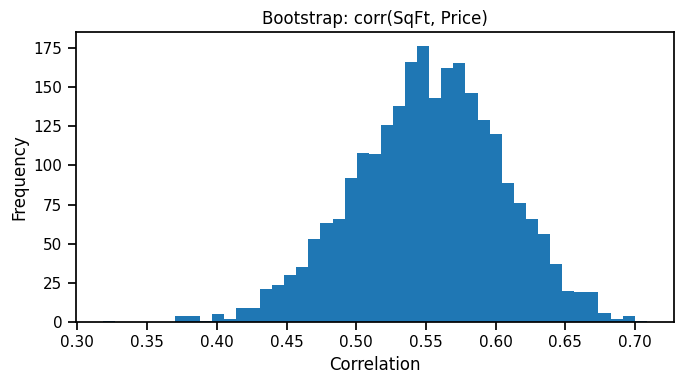

Diamonds Spearman corr: 0.9634311547065777
95% bootstrap CI: [0.96218261 0.96466623]


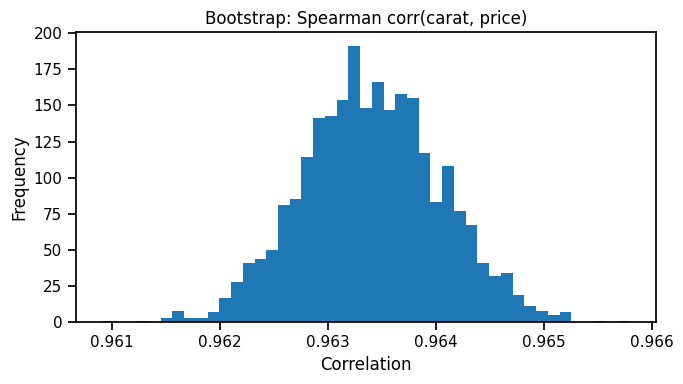

In [18]:
def bootstrap_corr(x: np.ndarray, y: np.ndarray, method='pearson', B=2500, seed=42):
    rng = np.random.default_rng(seed)
    n = len(x)
    stats = np.empty(B)
    for b in range(B):
        idx = rng.integers(0, n, size=n)
        xb = x[idx]
        yb = y[idx]
        stats[b] = pd.Series(xb).corr(pd.Series(yb), method=method)
    return stats

x = house['SqFt'].to_numpy(dtype=float)
y = house['Price'].to_numpy(dtype=float)
boot = bootstrap_corr(x, y, method='pearson', B=2500, seed=1)
ci = np.quantile(boot, [0.025, 0.975])
print('House Pearson corr:', pd.Series(x).corr(pd.Series(y)))
print('95% bootstrap CI:', ci)

plt.figure(figsize=(7,4))
plt.hist(boot, bins=45)
plt.title('Bootstrap: corr(SqFt, Price)')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

dd = diam_num.sample(min(12000, len(diam_num)), random_state=0)
x2 = dd['carat'].to_numpy(dtype=float)
y2 = dd['price'].to_numpy(dtype=float)
boot2 = bootstrap_corr(x2, y2, method='spearman', B=2500, seed=2)
ci2 = np.quantile(boot2, [0.025, 0.975])
print('Diamonds Spearman corr:', pd.Series(x2).corr(pd.Series(y2), method='spearman'))
print('95% bootstrap CI:', ci2)

plt.figure(figsize=(7,4))
plt.hist(boot2, bins=45)
plt.title('Bootstrap: Spearman corr(carat, price)')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()



## 10) Confounding and partial correlation (practical EDA)

If $X$ and $Y$ both depend on $Z$, the marginal correlation can be misleading.

A practical probe is partial correlation via residualization:

1. Regress $X$ on $Z$ and take residuals $r_X$.
2. Regress $Y$ on $Z$ and take residuals $r_Y$.
3. Compute Corr($r_X$, $r_Y$).

We apply this to diamonds: price vs x, controlling for carat.


In [19]:
def partial_corr(df: pd.DataFrame, x: str, y: str, z: str) -> float:
    d = df[[x, y, z]].dropna()
    Z = np.c_[np.ones(len(d)), d[z].to_numpy(dtype=float)]
    bx = np.linalg.lstsq(Z, d[x].to_numpy(dtype=float), rcond=None)[0]
    by = np.linalg.lstsq(Z, d[y].to_numpy(dtype=float), rcond=None)[0]
    rx = d[x].to_numpy(dtype=float) - Z @ bx
    ry = d[y].to_numpy(dtype=float) - Z @ by
    return float(pd.Series(rx).corr(pd.Series(ry)))

diam3 = diamonds[['price','carat','x','y','z']].dropna().sample(min(25000, len(diamonds)), random_state=123)
print('Corr(price, x):', diam3[['price','x']].corr().iloc[0,1])
print('Partial Corr(price, x | carat):', partial_corr(diam3, 'price', 'x', 'carat'))


Corr(price, x): 0.885428250360261
Partial Corr(price, x | carat): -0.14429361853002626



## 11) Simpson’s paradox: why subgroup scatterplots matter

Simpson’s paradox occurs when an association in the aggregated data differs from the association within subgroups.

A practical recipe:

1. Compute overall association.
2. Pick a plausible grouping variable.
3. Compute association within groups.
4. Plot with hue and compare slopes visually.

We demonstrate using diamonds grouped by cut.


Overall Spearman corr(carat, price): 0.9625621816824832


,spearman_corr
Very Good,0.969483
Good,0.960883
Premium,0.960510
Ideal,0.953750
Fair,0.890720


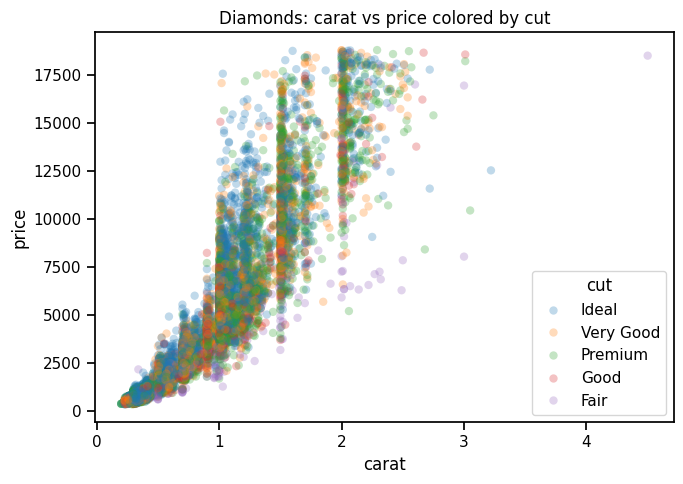

In [20]:
d2 = diamonds[['carat','price','cut']].dropna().copy()
d2s = d2.sample(min(14000, len(d2)), random_state=4)
overall = d2s[['carat','price']].corr(method='spearman').iloc[0,1]
print('Overall Spearman corr(carat, price):', overall)
group_corr = groupwise_corr(d2s, 'cut', 'carat', 'price', method='spearman')
display(group_corr.to_frame('spearman_corr'))

plt.figure(figsize=(7,5))
sns.scatterplot(data=d2s, x='carat', y='price', hue='cut', alpha=0.28, linewidth=0)
plt.title('Diamonds: carat vs price colored by cut')
plt.tight_layout()
plt.show()



## 12) Outliers and leverage: correlation sensitivity analysis

Pearson correlation is sensitive to extreme points. A robust diagnostic uses median/MAD-based z-scores:

- median: $\mathrm{med}(x)$
- MAD: $\mathrm{med}(|x-\mathrm{med}(x)|)$

Robust z-score approximation:

$$
z_i \approx \frac{x_i-\mathrm{med}(x)}{1.4826\cdot \mathrm{MAD}(x)}.
$$

We filter diamonds using robust z-scores and compare correlations.


Pearson all: 0.9215913011934687
Pearson filtered (|robust z|<5): 0.9189819284453488
Rows all: 53940 Rows filtered: 52191


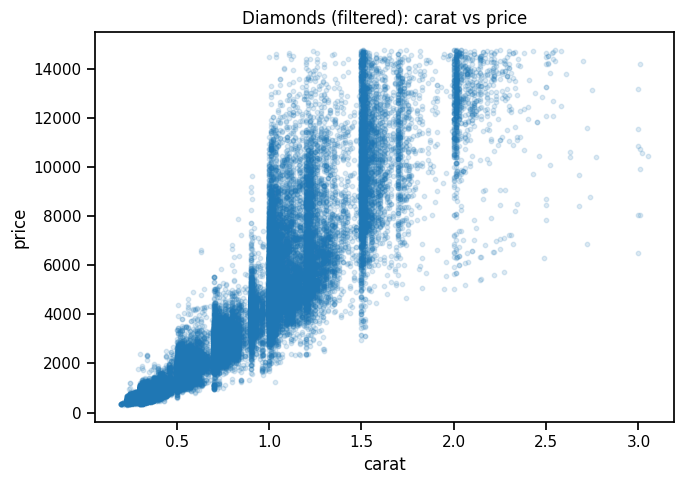

In [21]:
def robust_zscore(s: pd.Series) -> pd.Series:
    x = s.to_numpy(dtype=float)
    med = np.nanmedian(x)
    mad = np.nanmedian(np.abs(x - med))
    if mad == 0:
        return pd.Series(np.zeros_like(x), index=s.index)
    return pd.Series((x - med) / (1.4826 * mad), index=s.index)

tmp = diam_num[['carat','price']].copy()
tmp['z_price'] = robust_zscore(tmp['price'])
tmp['z_carat'] = robust_zscore(tmp['carat'])
r_all = tmp[['carat','price']].corr(method='pearson').iloc[0,1]
tmp_f = tmp[(tmp['z_price'].abs() < 5) & (tmp['z_carat'].abs() < 5)].copy()
r_f = tmp_f[['carat','price']].corr(method='pearson').iloc[0,1]
print('Pearson all:', r_all)
print('Pearson filtered (|robust z|<5):', r_f)
print('Rows all:', len(tmp), 'Rows filtered:', len(tmp_f))

plt.figure(figsize=(7,5))
plt.scatter(tmp_f['carat'], tmp_f['price'], alpha=0.15, s=10)
plt.title('Diamonds (filtered): carat vs price')
plt.xlabel('carat')
plt.ylabel('price')
plt.tight_layout()
plt.show()



## 13) Automating pairwise exploration: a mini “pairwise report”

EDA scales better when you automate. The report below:

- computes numeric correlation (Pearson or Spearman),
- lists top absolute correlations,
- plots scatter + fitted line for top pairs.

We run it on wine and house prices.


,,corr,abs_corr
density,alcohol,-0.821855,0.821855
alcohol,density,-0.821855,0.821855
density,residual sugar,0.780365,0.780365
residual sugar,density,0.780365,0.780365
total sulfur dioxide,free sulfur dioxide,0.618616,0.618616
free sulfur dioxide,total sulfur dioxide,0.618616,0.618616
chlorides,alcohol,-0.570806,0.570806


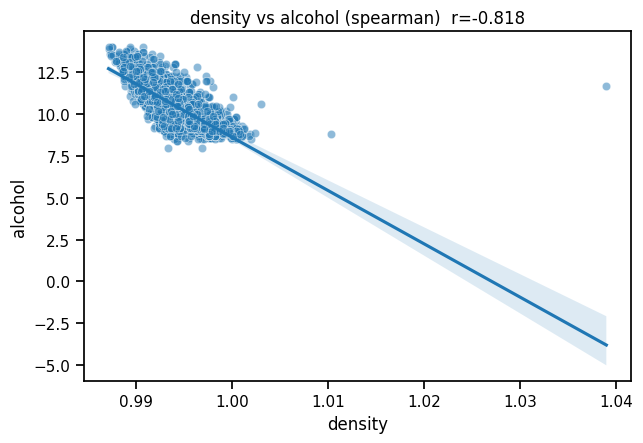

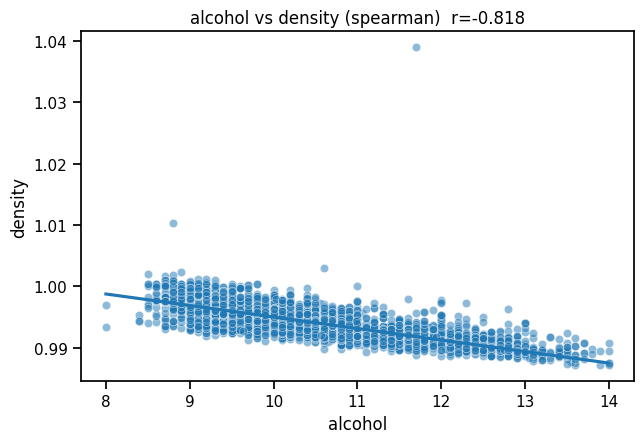

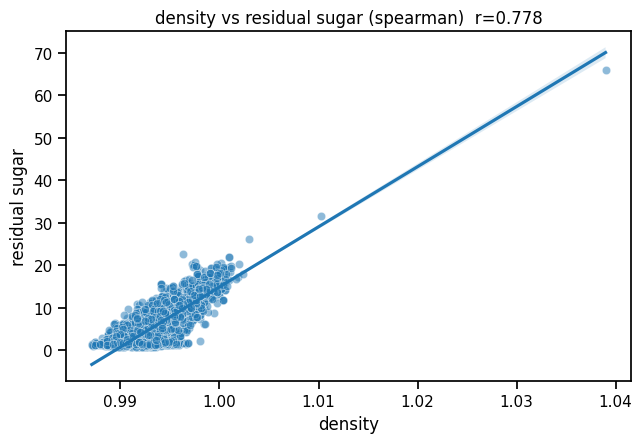

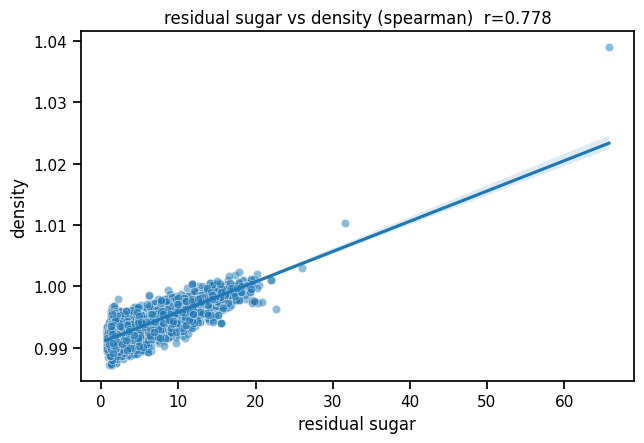

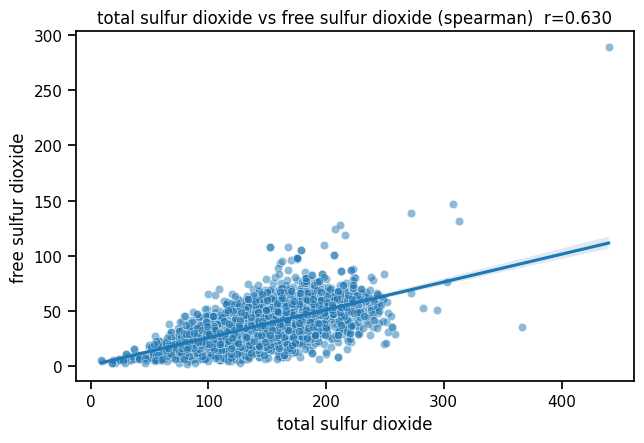

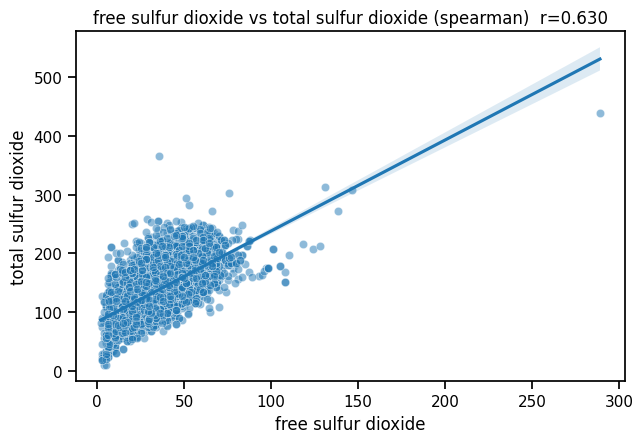

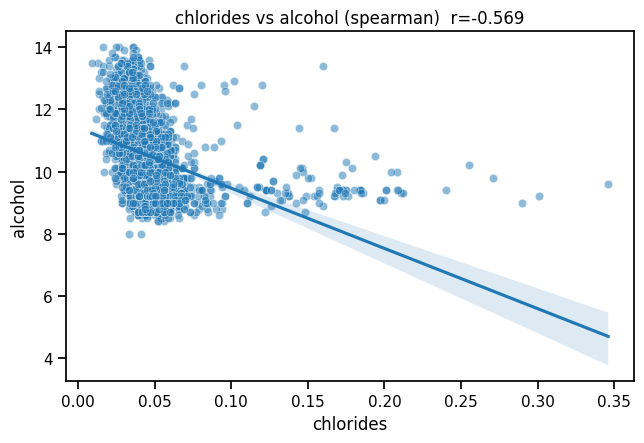

corr  abs_corr
SqFt      Price      0.552982  0.552982
Price     SqFt       0.552982  0.552982
          Bedrooms   0.525926  0.525926
Bedrooms  Price      0.525926  0.525926
Bathrooms Price      0.523258  0.523258
Price     Bathrooms  0.523258  0.523258

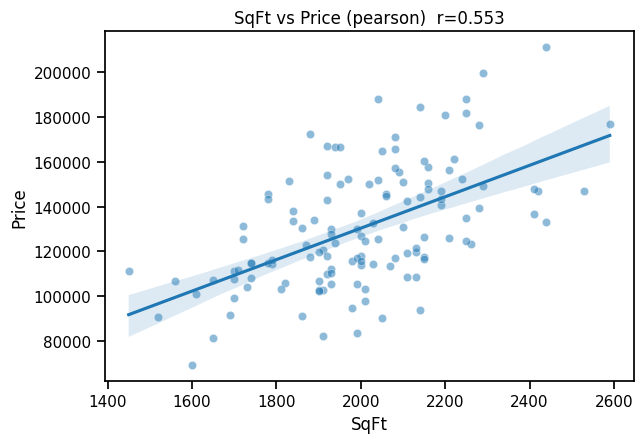

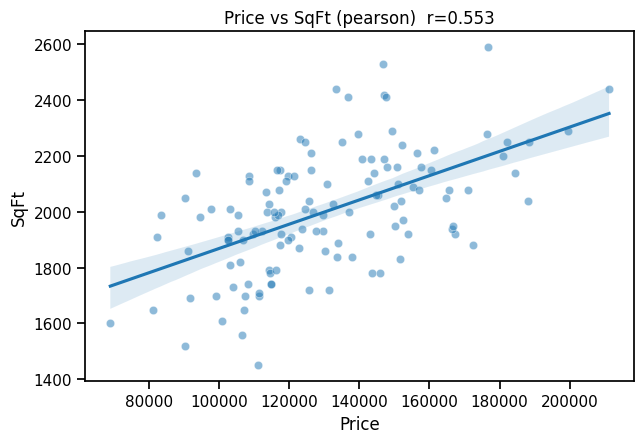

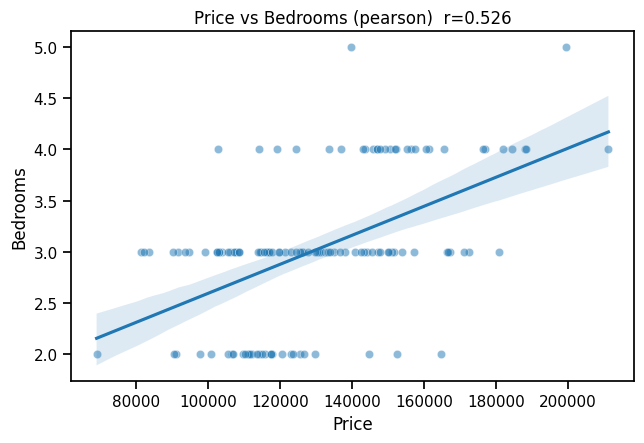

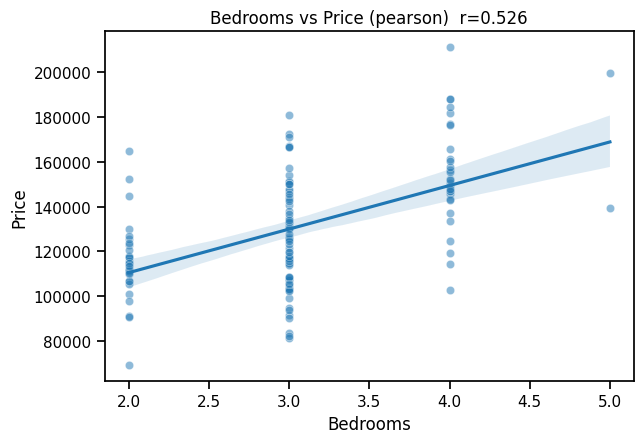

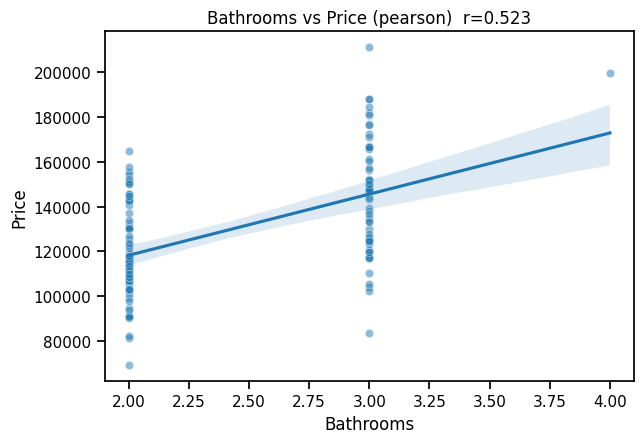

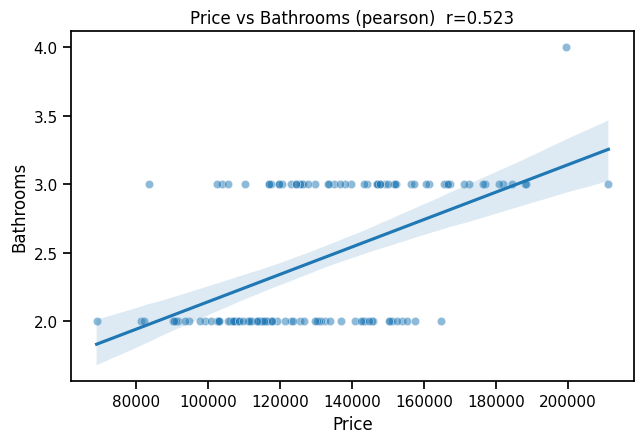

In [22]:
def pairwise_report(df: pd.DataFrame, *, method='pearson', top_k=8, sample_scatter=4000, random_state=0):
    df = coerce_numeric(df)
    num = numeric_columns(df)
    if len(num) < 2:
        print('Not enough numeric columns for pairwise report.')
        return
    corr = df[num].corr(method=method)
    top = top_abs_correlations(corr, k=top_k)
    display(top)
    for (a, b), row in top.iterrows():
        sub = df[[a, b]].dropna()
        if len(sub) > sample_scatter:
            sub = sub.sample(sample_scatter, random_state=random_state)
        r = pd.Series(sub[a]).corr(pd.Series(sub[b]), method=method)
        plt.figure(figsize=(6.6, 4.6))
        sns.scatterplot(data=sub, x=a, y=b, alpha=0.5)
        sns.regplot(data=sub, x=a, y=b, scatter=False)
        plt.title(f'{a} vs {b} ({method})  r={r:.3f}')
        plt.tight_layout()
        plt.show()

pairwise_report(wine, method='spearman', top_k=7)
pairwise_report(house, method='pearson', top_k=6)



## 14) Pairwise EDA checklist (model-ready)

### A) Identify variable types
- Numeric (continuous, integer counts, bounded scores)
- Categorical (nominal/ordinal)
- Date/time (often needs parsing and special care)
- Target variable (if supervised)

### B) Numeric ↔ numeric
- Correlation matrices: Pearson + Spearman
- Top pairs: inspect scatterplots
- Check for:
  - curvature → transform/nonlinear model,
  - heteroscedasticity → transform/robust loss,
  - outliers/leverage → robust checks,
  - near-duplicates → drop or dedupe,
  - clusters → consider interactions or segmentation.

### C) Numeric ↔ categorical/label
- Binary: point-biserial + box/violin plots
- Multi-class: $\eta^2$ and plots by group
- MI as a nonlinear screening alternative

### D) Categorical ↔ categorical
- Cramér’s $V$, contingency tables, heatmaps
- Rare categories and empty combinations

### E) Stability and slices
- Bootstrap intervals for key correlations
- Repeat key plots by subgroup (region, product type, cohort)

### F) Translate findings to modeling actions
- Transformations (log, power, interactions)
- Feature selection/deduplication
- Regularization strategies
- Model class suggestions (linear vs tree vs kernel)
- Leakage suspicions (too-perfect correlations, post-outcome variables)

---

## 15) Exercises

1) On **wine**, pick three top pairs from Spearman and compare Pearson vs Spearman for each pair. Use scatterplots to justify your interpretation.  
2) On **diamonds**, compare alpha scatter vs hexbin for carat vs price. Which shows density better and why?  
3) On **cognitive**, compute correlation between mom_iq and kid_score separately for mom_hs=yes and mom_hs=no. Compare to overall.  
4) On **stars**, compute $\eta^2$ for Temperature explained by Spectral_Class and for another numeric column (e.g., L). Compare.  
5) Choose another dataset from your repository (e.g., listings or NYC_Collisions) and write a short pairwise EDA summary with 4–6 numeric columns, one heatmap, and three key scatterplots.



## 16) Statistical testing for correlation (and why you should be cautious)

For Pearson correlation, under a bivariate normal assumption and $H_0:\rho=0$, the test statistic

$$
t = r\sqrt{\frac{n-2}{1-r^2}}
$$

follows a $t$ distribution with $n-2$ degrees of freedom.

Two important caveats in ML practice:

1. **Assumptions are often violated.** Heavy tails, outliers, and nonlinearities break the theory.
2. **Multiple comparisons explode false positives.** If you compute correlations among dozens of columns, many will look “significant” by chance.

Therefore, treat p-values as a *screening signal*, not a conclusion. Prefer effect sizes, plots, stability checks, and out-of-sample validation.

### 16.1) Example: many correlations → many small p-values

We compute Pearson correlations for wine features against `quality` and show p-values. Then we apply a simple Benjamini–Hochberg (BH) FDR adjustment to illustrate multiple testing control.


In [23]:
from scipy.stats import pearsonr

w = wine.dropna().copy()
target = 'quality' if 'quality' in w.columns else w.columns[-1]
features = [c for c in w.columns if c != target and pd.api.types.is_numeric_dtype(w[c])]

rows = []
for c in features:
    r, p = pearsonr(w[c].to_numpy(), w[target].to_numpy())
    rows.append((c, r, p))

res = pd.DataFrame(rows, columns=['feature','pearson_r','p_value']).sort_values('p_value')
display(res)

# Benjamini–Hochberg (BH) FDR adjustment (illustrative)
m = len(res)
res = res.reset_index(drop=True)
res['rank'] = np.arange(1, m+1)
res['bh_critical'] = (res['rank'] / m) * 0.05
res['bh_significant'] = res['p_value'] <= res['bh_critical']
display(res[['feature','pearson_r','p_value','bh_critical','bh_significant']])


,feature,pearson_r,p_value
10,alcohol,0.435575,5.614770e-226
7,density,-0.307123,1.727988e-107
4,chlorides,-0.209934,6.506542e-50
1,volatile acidity,-0.194723,4.673261e-43
6,total sulfur dioxide,-0.174737,6.991898e-35
0,fixed acidity,-0.113663,1.479886e-15
8,pH,0.099427,3.080613e-12
3,residual sugar,-0.097577,7.724005e-12
9,sulphates,0.053678,1.709792e-04
2,citric acid,-0.009209,5.193459e-01


,feature,pearson_r,p_value,bh_critical,bh_significant
0,alcohol,0.435575,5.614770e-226,0.004545,True
1,density,-0.307123,1.727988e-107,0.009091,True
2,chlorides,-0.209934,6.506542e-50,0.013636,True
3,volatile acidity,-0.194723,4.673261e-43,0.018182,True
4,total sulfur dioxide,-0.174737,6.991898e-35,0.022727,True
5,fixed acidity,-0.113663,1.479886e-15,0.027273,True
6,pH,0.099427,3.080613e-12,0.031818,True
7,residual sugar,-0.097577,7.724005e-12,0.036364,True
8,sulphates,0.053678,1.709792e-04,0.040909,True
9,citric acid,-0.009209,5.193459e-01,0.045455,False



## 17) Nonlinear dependence: distance correlation (optional but powerful)

Distance correlation is zero **if and only if** variables are independent (under mild conditions), unlike Pearson which only detects linear association.

We implement a simple distance correlation estimator. This gives you a robust “is there *any* dependence?” screening tool.

We test it on two cases:

- Linear: $Y = 3X + \epsilon$
- Nonlinear: $Y = X^2 + \epsilon$


In [24]:
def distance_correlation(x: np.ndarray, y: np.ndarray) -> float:
    x = x.reshape(-1, 1).astype(float)
    y = y.reshape(-1, 1).astype(float)
    n = x.shape[0]
    # Pairwise Euclidean distances
    a = np.abs(x - x.T)
    b = np.abs(y - y.T)
    # Double-centering
    A = a - a.mean(axis=0, keepdims=True) - a.mean(axis=1, keepdims=True) + a.mean()
    B = b - b.mean(axis=0, keepdims=True) - b.mean(axis=1, keepdims=True) + b.mean()
    dcov2 = (A * B).sum() / (n * n)
    dvarx = (A * A).sum() / (n * n)
    dvary = (B * B).sum() / (n * n)
    if dvarx <= 0 or dvary <= 0:
        return np.nan
    return float(np.sqrt(dcov2) / np.sqrt(np.sqrt(dvarx * dvary)))

rng = np.random.default_rng(10)
X = rng.uniform(-1, 1, size=800)
eps = rng.normal(0, 0.2, size=800)
Y_lin = 3*X + eps
Y_non = X**2 + eps

print('Pearson (linear):', pd.Series(X).corr(pd.Series(Y_lin)))
print('dCor   (linear):', distance_correlation(X, Y_lin))
print('Pearson (nonlinear):', pd.Series(X).corr(pd.Series(Y_non)))
print('dCor   (nonlinear):', distance_correlation(X, Y_non))


Pearson (linear): 0.9932160011552403
dCor   (linear): 0.9920791331693305
Pearson (nonlinear): 0.022235861995681137
dCor   (nonlinear): 0.4147709998955419
